In [1]:
%load_ext autoreload
%autoreload 2

import torch 
import os
import glob
from matplotlib import pyplot as plt

import matplotlib.animation as animation
import os
import torch
import numpy as np
import pandas as pd
# Cd to code
import os
import sys
os.chdir('/cluster/home/kheuto01/code/prob_diff_topk')
sys.path.append('/cluster/home/kheuto01/code/prob_diff_topk')


from distributions import ZeroInflatedDist, QuantizedNormal
from torch_models import MixtureOfTruncNormModel, SpatialWaves
from torch_training import train_epoch
from torch_perturb.torch_pert_topk import PerturbedTopK
import time
from torch_training import train_epoch_largesynth
from torch_models import torch_bpr_uncurried, deterministic_bpr

In [2]:
rows=27
cols=60
data_shape=(rows, cols)

In [3]:
deaths = pd.read_csv('deaths_band.csv')
pop = pd.read_csv('pop_band.csv')


In [18]:
# turn the death column into a time-by-geoid array
deaths_TS = deaths.pivot(index='time', columns='geoid', values='death').values
pop_S = pop['pop'].values

T, S = deaths_TS.shape
# create latitude and longitude arrays corresponding to the row and column index of the geoids when reshaped into data_shape
lat = np.linspace(-rows/2, rows/2, rows)
lon = np.linspace(-cols/2, cols/2, cols)
lat_S, lon_S = np.meshgrid(lon, lat)
lat_S = lat_S.flatten()
lon_S = lon_S.flatten()
# create column of time values
time_T = np.arange(deaths_TS.shape[0])
time_T = torch.tensor(time_T, dtype=torch.float32)
lat_S = torch.tensor(lat_S, dtype=torch.float32)
lon_S = torch.tensor(lon_S, dtype=torch.float32)
pop_S = torch.tensor(pop_S, dtype=torch.float32)
S = pop_S.shape[0]
T = time_T.shape[0]


model  = SpatialWaves(num_waves=1,low=0, high=1000000)

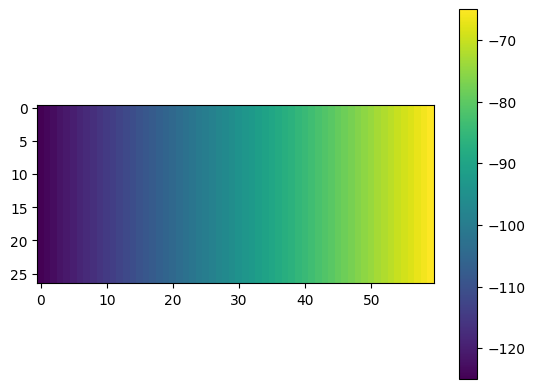

In [5]:
plt.imshow(lat_S.view(data_shape))
plt.colorbar()

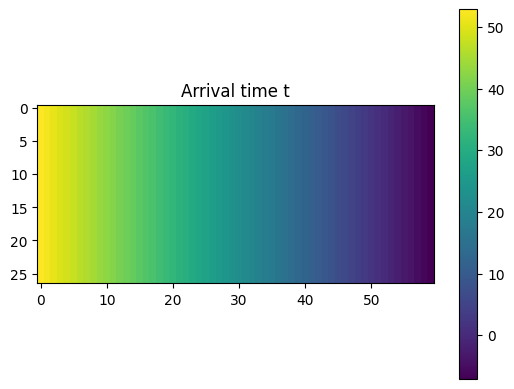

In [6]:
arrival_speed=torch.tensor([1])

lon_coeff = torch.tensor([0.0,])
lat_coeff = torch.tensor([-1.0])
arrival_intercept = torch.tensor([lat_S.view(data_shape)[0,52]]) 
mag=0.005
width=2
softinv_mags = torch.tensor([mag]) + torch.log(-torch.expm1(torch.tensor(-np.array([mag]))))
softinv_widths = torch.tensor([width]) + torch.log(-torch.expm1(torch.tensor(-np.array([width]))))
plt.title('Arrival time t')
plt.imshow((arrival_intercept + lat_coeff*lat_S + lon_coeff*lon_S).view(data_shape))
plt.colorbar()
model.update_params(torch.cat([arrival_speed, arrival_intercept, lat_coeff, lon_coeff, softinv_mags, softinv_widths]))

In [7]:
softinv_mags

tensor([-5.2958], dtype=torch.float64)

In [8]:
dist = model(time_T,pop_S, lat_S, lon_S)
y_sample_TMS = dist.sample((20, )).permute(1, 0, 2)

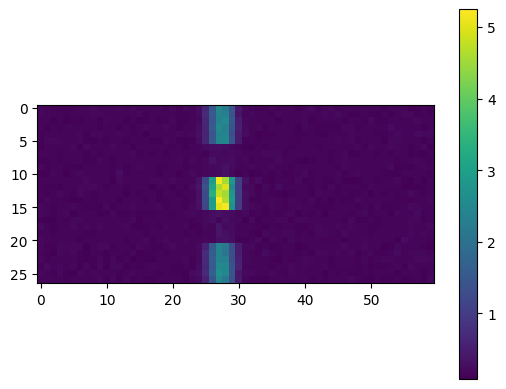

In [9]:
dist = model(time_T,pop_S, lat_S, lon_S)
y_sample_TMS = dist.sample((20, )).permute(1, 0, 2)
plt.imshow(y_sample_TMS.mean(1)[25,:].view(data_shape))
plt.colorbar()

In [10]:
def calc_nll_bpr(model, K, M_score_func,
                 time_T,pop_S, lat_S, lon_S, train_y_TS,
                 perturbed_top_K_func):

    dist = model(time_T,pop_S, lat_S, lon_S)
    
    y_sample_TMS = dist.sample((M_score_func,)).permute(1, 0, 2)
    y_sample_action_TMS = y_sample_TMS

    ratio_rating_TMS = y_sample_action_TMS/y_sample_action_TMS.sum(dim=-1, keepdim=True)
    ratio_rating_TS =  ratio_rating_TMS.mean(dim=1)
    ratio_rating_TS.requires_grad_(True)
 

    positive_bpr_T = torch_bpr_uncurried(ratio_rating_TS, torch.tensor(train_y_TS), K=K, perturbed_top_K_func=perturbed_top_K_func)

    
    nll = torch.mean(-dist.log_prob( torch.tensor(train_y_TS)))


    deterministic_bpr_T = deterministic_bpr(ratio_rating_TS, torch.tensor(train_y_TS), K=K)
    det_bpr =torch.mean(deterministic_bpr_T)


    return  det_bpr.detach(), nll.detach(), model

In [56]:
step_size = 0.001
K=50
optimizer = torch.optim.Adam(model.parameters(), lr=step_size)
M_score_func = 20
perturbed_top_K_func = PerturbedTopK(k=K, sigma=0.0001, num_samples=20)

In [57]:
bpr, nll, model = calc_nll_bpr(model, K,
                                    M_score_func, time_T,pop_S,
                                    lat_S, lon_S, deaths_TS, 
                                    perturbed_top_K_func, )

In [58]:
arrival_speed=torch.tensor([1])
lon_coeff = torch.tensor([0.0,])
lat_coeff = torch.tensor([-1.0])
arrival_intercept = torch.tensor([lat_S.view(data_shape)[0,52]]) 
mag=0.005
width=2
softinv_mags = torch.tensor([mag]) + torch.log(-torch.expm1(torch.tensor(-np.array([mag]))))
softinv_widths = torch.tensor([width]) + torch.log(-torch.expm1(torch.tensor(-np.array([width]))))

model.update_params(torch.cat([arrival_speed, arrival_intercept, lat_coeff, lon_coeff, softinv_mags, softinv_widths]))

# search 20 widths from 0.1 to 6
bprs = []
nlls = []
wid_grid = np.linspace(0.1, 15, 200)
for width in wid_grid:
    print(f'width: {width}')
    softinv_widths = torch.tensor([width]) + torch.log(-torch.expm1(torch.tensor(-np.array([width]))))
    model.update_params(torch.cat([arrival_speed, arrival_intercept, lat_coeff, lon_coeff, softinv_mags, softinv_widths]))
    bpr, nll, model = calc_nll_bpr(model, K,
                                    M_score_func, time_T,pop_S,
                                    lat_S, lon_S, deaths_TS, 
                                    perturbed_top_K_func, )
    bprs.append(bpr)
    nlls.append(nll)
    sys.stdout.flush() 


width: 0.1
width: 0.1748743718592965
width: 0.24974874371859299
width: 0.3246231155778895
width: 0.39949748743718594
width: 0.4743718592964824
width: 0.549246231155779
width: 0.6241206030150754
width: 0.6989949748743719
width: 0.7738693467336684
width: 0.8487437185929648
width: 0.9236180904522614
width: 0.9984924623115579
width: 1.0733668341708544
width: 1.148241206030151
width: 1.2231155778894474
width: 1.297989949748744
width: 1.3728643216080405
width: 1.4477386934673369
width: 1.5226130653266334
width: 1.5974874371859298
width: 1.6723618090452264
width: 1.747236180904523
width: 1.8221105527638193
width: 1.8969849246231159
width: 1.9718592964824124
width: 2.046733668341709
width: 2.1216080402010054
width: 2.196482412060302
width: 2.2713567839195985
width: 2.3462311557788946
width: 2.421105527638191
width: 2.4959798994974878
width: 2.5708542713567843
width: 2.645728643216081
width: 2.720603015075377
width: 2.7954773869346736
width: 2.87035175879397
width: 2.9452261306532668
width: 3.0

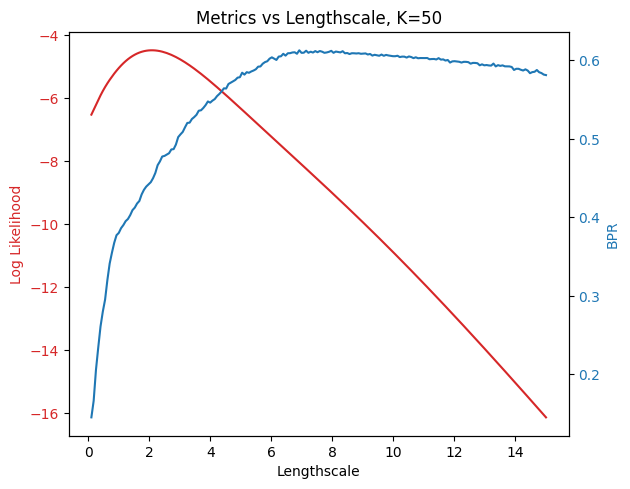

In [59]:
# plot bpr and nll  on separate y axes
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Lengthscale')
ax1.set_ylabel('Log Likelihood', color=color)
ax1.plot(wid_grid, -np.array(nlls), color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('BPR', color=color)  # we already handled the x-label with ax1
ax2.plot(wid_grid, bprs, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(f'Metrics vs Lengthscale, K={K}')
plt.show()


In [45]:
best_nll_width = 2
best_bpr_width = 7

In [49]:
# search 20 widths from 0.1 to 6
bprs = []
nlls = []
width= best_nll_width
mag_grid = np.linspace(0.001, 0.5, 200)
for mag in mag_grid:

    arrival_speed=torch.tensor([1])
    lon_coeff = torch.tensor([0.0,])
    lat_coeff = torch.tensor([-1.0])
    arrival_intercept = torch.tensor([lat_S.view(data_shape)[0,52]]) 
    softinv_mags = torch.tensor([mag]) + torch.log(-torch.expm1(torch.tensor(-np.array([mag]))))
    softinv_widths = torch.tensor([width]) + torch.log(-torch.expm1(torch.tensor(-np.array([width]))))

    model.update_params(torch.cat([arrival_speed, arrival_intercept, lat_coeff, lon_coeff, softinv_mags, softinv_widths]))
    bpr, nll, model = calc_nll_bpr(model, K,
                                M_score_func, time_T,pop_S,
                                lat_S, lon_S, deaths_TS, 
                                perturbed_top_K_func, )
    bprs.append(bpr)
    nlls.append(nll)



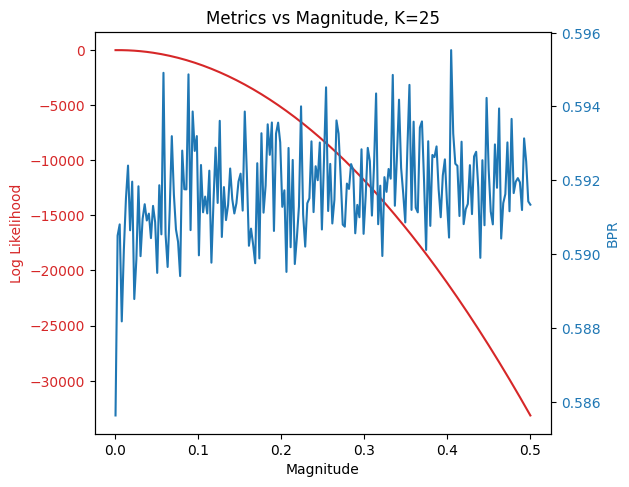

In [55]:
# plot bpr and nll  on separate y axes
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Magnitude')
ax1.set_ylabel('Log Likelihood', color=color)
ax1.plot(mag_grid, -np.array(nlls), color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('BPR', color=color)  # we already handled the x-label with ax1
ax2.plot(mag_grid, bprs, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(f'Metrics vs Magnitude, K={K}')
plt.show()


In [56]:
best_mag = 0.003

In [58]:
bprs = []
nlls = []
mag= best_mag
width= best_nll_width
coeff_grid = np.linspace(-5, 5, 25)
for l,lat_coeff in  enumerate(coeff_grid):
    if l%10==0:
        print(f'Percent done: {l/len(coeff_grid)}')
    bpr_row = []
    nll_row = []
    for lon_coeff in coeff_grid:
        arrival_speed=torch.tensor([1])
        arrival_intercept = torch.tensor([lat_S.view(data_shape)[0,52]]) 
        softinv_mags = torch.tensor([mag]) + torch.log(-torch.expm1(torch.tensor(-np.array([mag]))))
        softinv_widths = torch.tensor([width]) + torch.log(-torch.expm1(torch.tensor(-np.array([width]))))
        lat_coeff = torch.tensor([lat_coeff])
        lon_coeff = torch.tensor([lon_coeff])
        model.update_params(torch.cat([arrival_speed, arrival_intercept, lat_coeff, lon_coeff, softinv_mags, softinv_widths]))
        bpr, nll, model = calc_nll_bpr(model, K,
                                M_score_func, time_T,pop_S,
                                lat_S, lon_S, deaths_TS, 
                                perturbed_top_K_func, )
        bpr_row.append(bpr)
        nll_row.append(nll)
    bprs.append(bpr_row)
    nlls.append(nll_row)

Percent done: 0.0
Percent done: 0.4
Percent done: 0.8


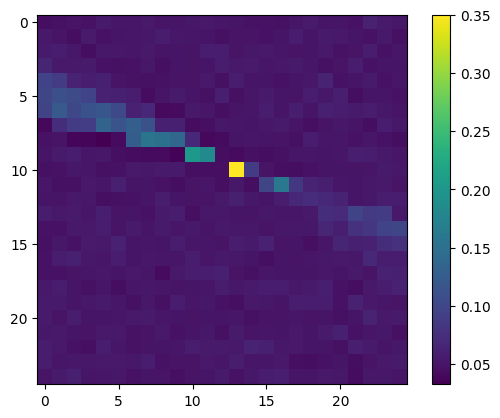

In [62]:
plt.imshow(np.array(bprs))
plt.colorbar()

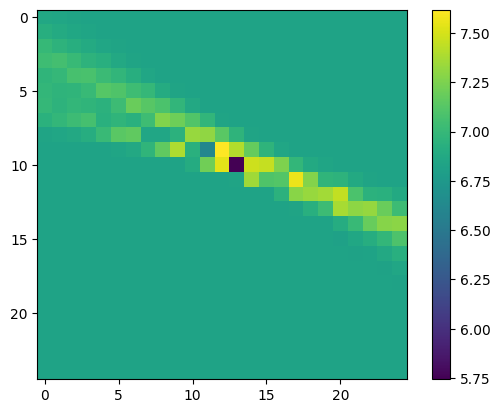

In [61]:
plt.imshow(np.array(nlls))
plt.colorbar()

In [67]:
coeff_grid[12]

0.0

In [60]:
arrival_speed=torch.tensor([1])

lon_coeff = torch.tensor([0.0,])
lat_coeff = torch.tensor([-1.0])
arrival_intercept = torch.tensor([lat_S.view(data_shape)[0,52]]) 
mag=best_mag
width=best_bpr_width
softinv_mags = torch.tensor([mag]) + torch.log(-torch.expm1(torch.tensor(-np.array([mag]))))
softinv_widths = torch.tensor([width]) + torch.log(-torch.expm1(torch.tensor(-np.array([width]))))
model.update_params(torch.cat([arrival_speed, arrival_intercept, lat_coeff, lon_coeff, softinv_mags, softinv_widths]))
bpr, nll, model = calc_nll_bpr(model, K,
                                M_score_func, time_T,pop_S,
                                lat_S, lon_S, deaths_TS, 
                                perturbed_top_K_func, )
dist = model(time_T,pop_S, lat_S, lon_S)
y_sample_TMS = dist.sample((20, )).permute(1, 0, 2)
plt.imshow(y_sample_TMS.mean(1)[25,:].view(data_shape))
plt.colorbar()
plt.title('BPR width prediction')
# plot a mask of the top K values of the truth
plt.figure()
top_K_mask = np.zeros(data_shape)
top_K_mask[np.unravel_index(np.argsort(y_sample_TMS.mean(1)[25,:], axis=None)[-K:], data_shape)] = 1
plt.imshow(top_K_mask)#*deaths_TS[25,:].reshape(data_shape))
plt.title(f"Top K={K} mask, BPR prediction")
plt.colorbar()
print(f'bpr: {bpr}, nll: {nll}')

NameError: name 'best_mag' is not defined

bpr: 0.5910360774505377, nll: 4.636426788806876


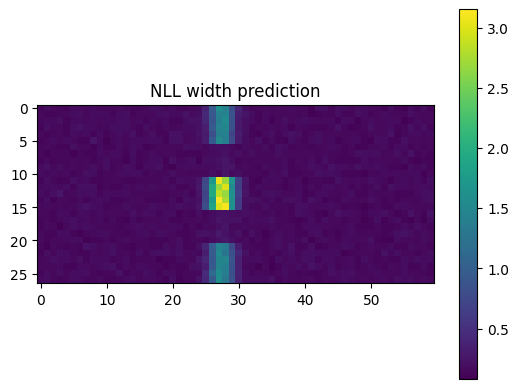

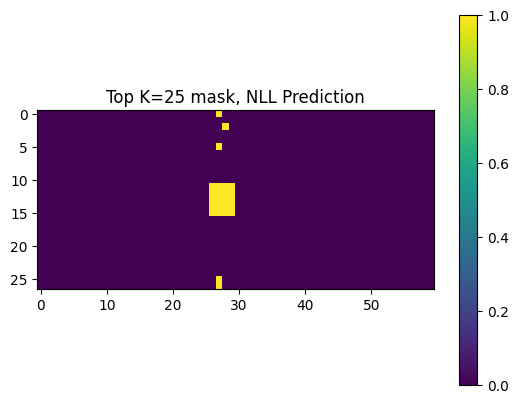

In [104]:
arrival_speed=torch.tensor([1])

lon_coeff = torch.tensor([0.0,])
lat_coeff = torch.tensor([-1.0])
arrival_intercept = torch.tensor([lat_S.view(data_shape)[0,52]]) 
mag=best_mag
width=best_nll_width
softinv_mags = torch.tensor([mag]) + torch.log(-torch.expm1(torch.tensor(-np.array([mag]))))
softinv_widths = torch.tensor([width]) + torch.log(-torch.expm1(torch.tensor(-np.array([width]))))
model.update_params(torch.cat([arrival_speed, arrival_intercept, lat_coeff, lon_coeff, softinv_mags, softinv_widths]))
bpr, nll, model = calc_nll_bpr(model, K,
                                M_score_func, time_T,pop_S,
                                lat_S, lon_S, deaths_TS, 
                                perturbed_top_K_func, )
dist = model(time_T,pop_S, lat_S, lon_S)
y_sample_TMS = dist.sample((20, )).permute(1, 0, 2)
plt.imshow(y_sample_TMS.mean(1)[25,:].view(data_shape))
plt.colorbar()
plt.title('NLL width prediction')
# plot a mask of the top K values of the truth
plt.figure()
top_K_mask = np.zeros(data_shape)
top_K_mask[np.unravel_index(np.argsort(y_sample_TMS.mean(1)[25,:], axis=None)[-K:], data_shape)] = 1
plt.imshow(top_K_mask)#*deaths_TS[25,:].reshape(data_shape))
plt.title(f"Top K={K} mask, NLL Prediction")
plt.colorbar()
print(f'bpr: {bpr}, nll: {nll}')

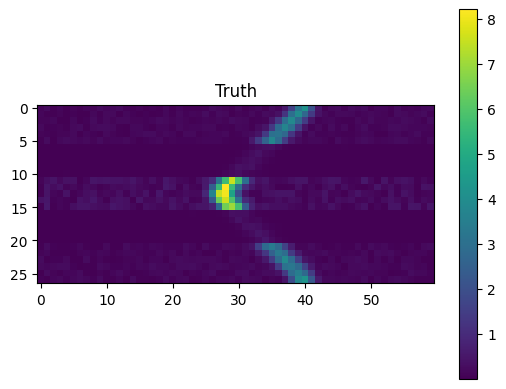

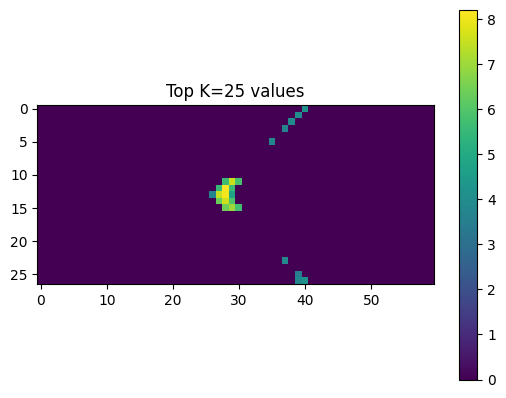

In [105]:
plt.imshow(deaths_TS[25,:].reshape(data_shape))
plt.title("Truth")
plt.colorbar()
# plot a mask of the top K values of the truth
plt.figure()
top_K_mask = np.zeros(data_shape)
top_K_mask[np.unravel_index(np.argsort(deaths_TS[25,:], axis=None)[-K:], data_shape)] = 1
plt.imshow(top_K_mask*deaths_TS[25,:].reshape(data_shape))
plt.title(f"Top K={K} values")
plt.colorbar()

array([[0.11582782, 0.242345  , 0.05793488, ..., 0.08148676, 0.18360786,
        0.21204465],
       [0.13848827, 0.06194089, 0.04099664, ..., 0.18333588, 0.23073913,
        0.07584785],
       [0.11931028, 0.10640353, 0.16158055, ..., 0.14234817, 0.04452786,
        0.23315362],
       ...,
       [0.20355759, 0.14648994, 0.19264876, ..., 0.10645904, 0.14442791,
        0.02540303],
       [0.02160006, 0.24633438, 0.11071414, ..., 0.18186654, 0.182052  ,
        0.09542458],
       [0.09047526, 0.02576487, 0.15736265, ..., 0.06138814, 0.04398396,
        0.04777455]])

In [15]:
good_exp = '/cluster/tufts/hugheslab/kheuto01/large_synth_band_4000/bw0_nw1_ss0.1_nss100_nps100'

In [61]:
model = SpatialWaves(num_waves=1, low=0, high=100000)
model.load_state_dict(torch.load(good_exp + '/model.pth'))

<All keys matched successfully>

bpr: 0.7143305234926731, nll: 2.6123810194171364


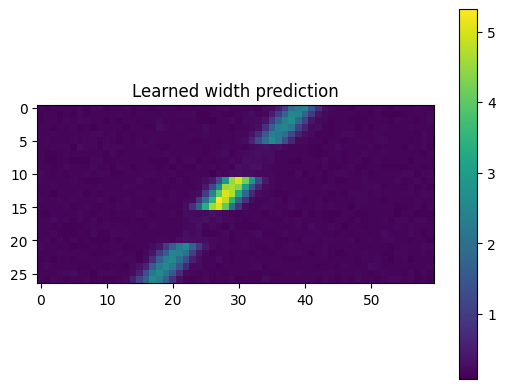

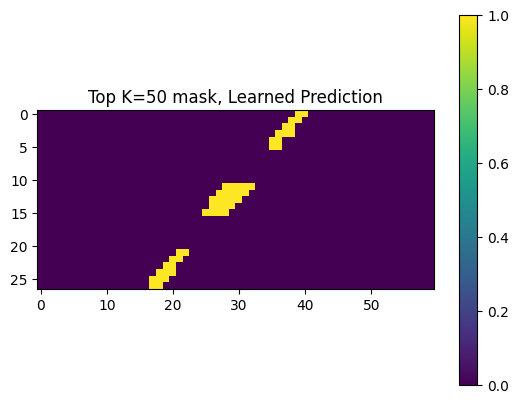

In [62]:
bpr, nll, model = calc_nll_bpr(model, K,
                                M_score_func, time_T,pop_S,
                                lat_S, lon_S, deaths_TS, 
                                perturbed_top_K_func, )
dist = model(time_T,pop_S, lat_S, lon_S)
y_sample_TMS = dist.sample((20, )).permute(1, 0, 2)
plt.imshow(y_sample_TMS.mean(1)[25,:].view(data_shape))
plt.colorbar()
plt.title('Learned width prediction')
# plot a mask of the top K values of the truth
plt.figure()
top_K_mask = np.zeros(data_shape)
top_K_mask[np.unravel_index(np.argsort(y_sample_TMS.mean(1)[25,:], axis=None)[-K:], data_shape)] = 1
plt.imshow(top_K_mask)#*deaths_TS[25,:].reshape(data_shape))
plt.title(f"Top K={K} mask, Learned Prediction")
plt.colorbar()
print(f'bpr: {bpr}, nll: {nll}')

In [36]:
K=25

In [63]:
learned_params = model.params_to_single_tensor()
arrival_speeds, arrival_intercepts, lat_coeff, lon_coeff, softinv_mags, softinv_widths = model.single_tensor_to_params(learned_params)

arrival_intercept = torch.tensor([lat_S.view(data_shape)[0,52]]) 

# search 20 widths from 0.1 to 6
bprs = []
nlls = []
wid_grid = np.linspace(0.1, 15, 200)
for width in wid_grid:
    softinv_widths = torch.tensor([width]) + torch.log(-torch.expm1(torch.tensor(-np.array([width]))))
    model.update_params(torch.cat([arrival_speeds, arrival_intercepts, lat_coeff, lon_coeff, softinv_mags, softinv_widths]))
    bpr, nll, model = calc_nll_bpr(model, K,
                                    M_score_func, time_T,pop_S,
                                    lat_S, lon_S, deaths_TS, 
                                    perturbed_top_K_func, )
    bprs.append(bpr)
    nlls.append(nll)


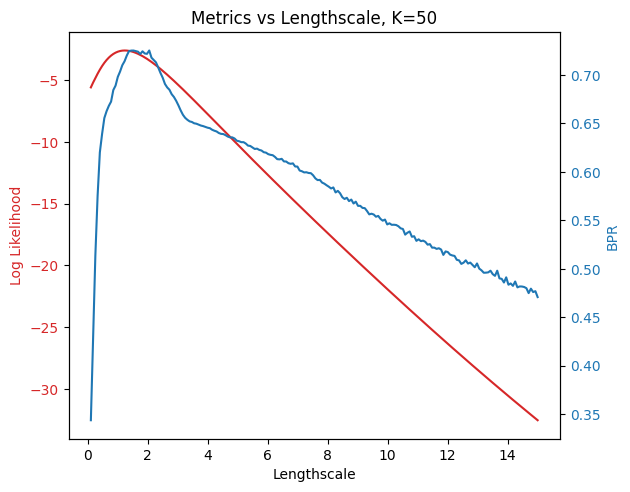

In [64]:
# plot bpr and nll  on separate y axes
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Lengthscale')
ax1.set_ylabel('Log Likelihood', color=color)
ax1.plot(wid_grid, -np.array(nlls), color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('BPR', color=color)  # we already handled the x-label with ax1
ax2.plot(wid_grid, bprs, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(f'Metrics vs Lengthscale, K={K}')
plt.show()


In [65]:
# Get width at max bpr and max nll
best_nll_idx = np.argmin(nlls)
best_bpr_idx = np.argmax(bprs)
best_nll_width = wid_grid[best_nll_idx]
best_bpr_width = wid_grid[best_bpr_idx]


bpr: 0.7128010643300066, nll: 2.6124535844576835


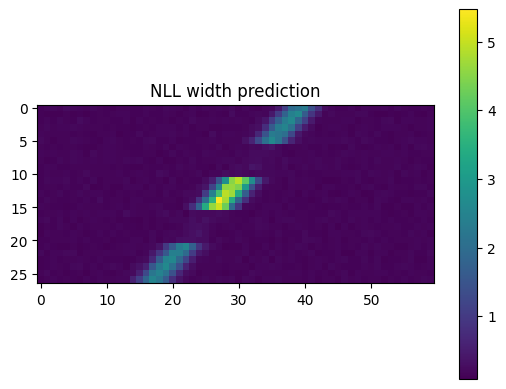

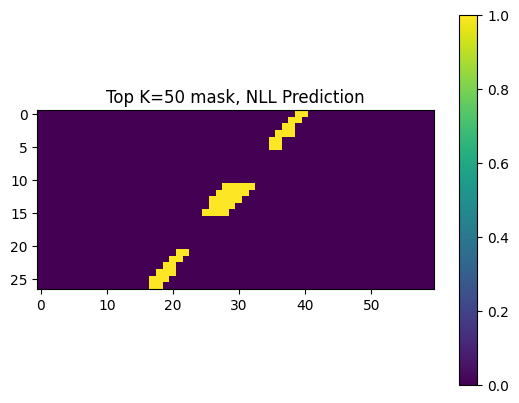

In [66]:

width=best_nll_width
softinv_widths = torch.tensor([width]) + torch.log(-torch.expm1(torch.tensor(-np.array([width]))))
model.update_params(torch.cat([arrival_speeds, arrival_intercepts, lat_coeff, lon_coeff, softinv_mags, softinv_widths]))
bpr, nll, model = calc_nll_bpr(model, K,
                                M_score_func, time_T,pop_S,
                                lat_S, lon_S, deaths_TS, 
                                perturbed_top_K_func, )
dist = model(time_T,pop_S, lat_S, lon_S)
y_sample_TMS = dist.sample((20, )).permute(1, 0, 2)
plt.imshow(y_sample_TMS.mean(1)[25,:].view(data_shape))
plt.colorbar()
plt.title('NLL width prediction')
# plot a mask of the top K values of the truth
plt.figure()
top_K_mask = np.zeros(data_shape)
top_K_mask[np.unravel_index(np.argsort(y_sample_TMS.mean(1)[25,:], axis=None)[-K:], data_shape)] = 1
plt.imshow(top_K_mask)#*deaths_TS[25,:].reshape(data_shape))
plt.title(f"Top K={K} mask, NLL Prediction")
plt.colorbar()
print(f'bpr: {bpr}, nll: {nll}')

bpr: 0.7219774287398337, nll: 3.4098626634157685


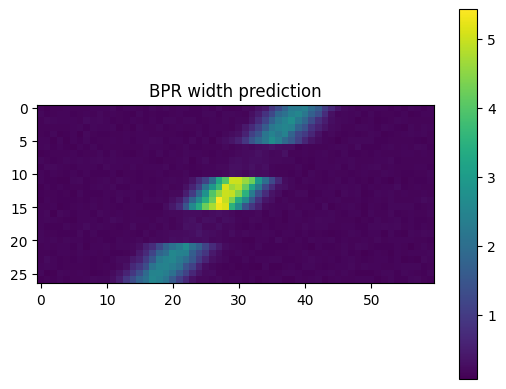

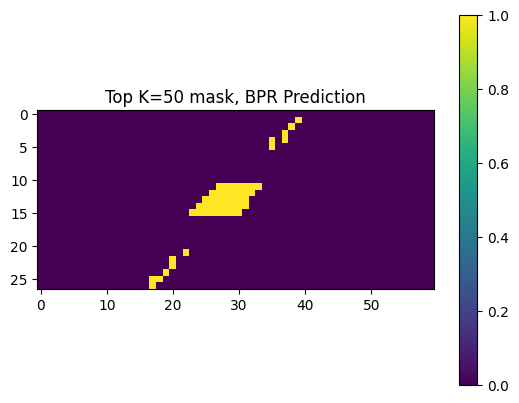

In [67]:

width=best_bpr_width
softinv_widths = torch.tensor([width]) + torch.log(-torch.expm1(torch.tensor(-np.array([width]))))
model.update_params(torch.cat([arrival_speeds, arrival_intercepts, lat_coeff, lon_coeff, softinv_mags, softinv_widths]))
bpr, nll, model = calc_nll_bpr(model, K,
                                M_score_func, time_T,pop_S,
                                lat_S, lon_S, deaths_TS, 
                                perturbed_top_K_func, )
dist = model(time_T,pop_S, lat_S, lon_S)
y_sample_TMS = dist.sample((20, )).permute(1, 0, 2)
plt.imshow(y_sample_TMS.mean(1)[25,:].view(data_shape))
plt.colorbar()
plt.title('BPR width prediction')
# plot a mask of the top K values of the truth
plt.figure()
top_K_mask = np.zeros(data_shape)
top_K_mask[np.unravel_index(np.argsort(y_sample_TMS.mean(1)[25,:], axis=None)[-K:], data_shape)] = 1
plt.imshow(top_K_mask)#*deaths_TS[25,:].reshape(data_shape))
plt.title(f"Top K={K} mask, BPR Prediction")
plt.colorbar()
print(f'bpr: {bpr}, nll: {nll}')